# Starring: VGG16 & KAN

## Classical VGG16

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

class vgg16_conv_block(nn.Module):
    def __init__(self, input_channels, out_channels, rate=0.4, drop=True):
        super().__init__()
        self.conv = nn.Conv2d(input_channels, out_channels, 3 ,1, 1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(rate)
        self.drop =drop
    def forward(self, x):
        x = self.relu(self.bn(self.conv(x)))
        if self.drop:
            x = self.dropout(x)
        return(x)

def vgg16_layer(input_channels, out_channels, num, dropout=[0.4, 0.4]):
    result = []
    result.append(vgg16_conv_block(input_channels, out_channels, dropout[0]))
    for i in range(1, num-1):
        result.append(vgg16_conv_block(out_channels, out_channels, dropout[1]))
    if num>1:
        result.append(vgg16_conv_block(out_channels, out_channels, drop=False))
    result.append(nn.MaxPool2d(2,2))
    return(result)

#b1是卷积层，b2是全连接层， *是对序列进行解包
b1 = nn.Sequential(*vgg16_layer(3,64,2,[0.3,0.4]), *vgg16_layer(64,128,2), *vgg16_layer(128,256,3), 
                   *vgg16_layer(256,512,3),*vgg16_layer(512,512,3))
b2 = nn.Sequential(nn.Dropout(0.5), nn.Flatten(), nn.Linear(512, 512, bias=True), nn.BatchNorm1d(512), nn.ReLU(inplace=True), 
                  nn.Linear(512,10, bias=True))



## Supernova KAN

In [ ]:
import torch
import torch.nn.functional as F
import math


class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.view(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        output = base_output + spline_output
        
        output = output.view(*original_shape[:-1], self.out_features)
        return output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features) intermediate tensor, which is hidden
        behind the F.linear function if we want an memory efficient implementation.

        The L1 regularization is now computed as mean absolute value of the spline
        weights. The authors implementation also includes this term in addition to the
        sample-based regularization.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


class KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )

# Introduce CIFAR10

In [ ]:
# 定义数据预处理和变换，增加更多数据增强操作
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # 随机裁剪，带有填充
    transforms.RandomHorizontalFlip(),  # 随机水平翻转
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # 颜色抖动
    transforms.RandomRotation(15),  # 随机旋转
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# 下载并加载CIFAR-10训练集和测试集
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
]))
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

import matplotlib.pyplot as plt
import numpy as np


# CIFAR-10类别标签
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 打印部分数据
def imshow(img):
    # img = img / 2 + 0.5  # 反归一化
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))  # 调整图像显示的大小
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 获取一些随机的数据
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 显示图像
imshow(torchvision.utils.make_grid(images))
# 打印标签
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
# 打印图像和标签的维度
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

# Make the Train

## VGG16 Train

In [ ]:
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, recall_score, f1_score
import matplotlib.pyplot as plt

# 创建模型实例
# net = CIFAR10VGG16()
net = nn.Sequential(b1, b2)

# 如果有GPU，使用GPU进行训练
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

# 定义损失函数和优化器，添加L2正则化
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=3e-4, weight_decay=1e-5)  # L2正则化项
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)  # 带动量的SGD和L2正则化项

# 记录指标的列表
vgg_train_losses = []
vgg_train_accuracies = []

vgg_test_losses = []
vgg_test_accuracies = []

# 训练模型
num_epochs = 30
for epoch in range(num_epochs):
    net.train()
    vgg_running_loss = 0.0
    vgg_all_labels = []
    vgg_all_preds = []
    progress_bar = tqdm(enumerate(trainloader, 0), total=len(trainloader), desc=f"Epoch {epoch+1}/{num_epochs}")
    for i, data in progress_bar:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        vgg_running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        vgg_all_labels.extend(labels.cpu().numpy())
        vgg_all_preds.extend(preds.cpu().numpy())
        
        vgg_accuracy = accuracy_score(vgg_all_labels, vgg_all_preds)
        
        progress_bar.set_postfix(vgg_train_loss=vgg_running_loss/(i+1), vgg_train_accuracy=vgg_accuracy)
    
    # 记录每个epoch的训练指标
    vgg_train_losses.append(vgg_running_loss / len(trainloader))
    vgg_train_accuracies.append(vgg_accuracy)
    
    # 在测试集上评估模型
    net.eval()
    vgg_test_running_loss = 0.0
    vgg_all_test_labels = []
    vgg_all_test_preds = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            vgg_test_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            vgg_all_test_labels.extend(labels.cpu().numpy())
            vgg_all_test_preds.extend(predicted.cpu().numpy())
    
    vgg_test_accuracy = accuracy_score(vgg_all_test_labels, vgg_all_test_preds)
    
    # 记录每个epoch的测试指标
    vgg_test_losses.append(vgg_test_running_loss / len(testloader))
    vgg_test_accuracies.append(vgg_test_accuracy)

    # 更新进度条，显示测试集指标
    progress_bar.set_postfix(vgg_train_loss=vgg_running_loss/len(trainloader), vgg_train_accuracy=vgg_accuracy,
                             vgg_test_loss=vgg_test_running_loss/len(testloader), vgg_test_accuracy=vgg_test_accuracy)

print('Finished Training')

# 绘制训练和测试的损失、准确率
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(vgg_train_losses, label='VGG Train Loss')
plt.plot(vgg_test_losses, label='VGG Test Loss')
plt.legend()
plt.title('VGG Loss')
plt.savefig('VGG_loss.png')

plt.subplot(1, 2, 2)
plt.plot(vgg_train_accuracies, label='VGG Train Accuracy')
plt.plot(vgg_test_accuracies, label='VGG Test Accuracy')
plt.legend()
plt.title('VGG Accuracy')
plt.savefig('VGG_accuracy.png')

plt.tight_layout()
plt.savefig('VGG_metrics.png')
plt.show()


## KAN Train

In [ ]:
# 定义模型
input_dim = 32 * 32 * 3  # CIFAR-10 图像的展平尺寸
num_classes = 10  # CIFAR-10 数据集的类别数
layers_hidden = [input_dim, 128, 64, num_classes]  # 根据需要调整隐藏层
kan_model = KAN(layers_hidden=layers_hidden, grid_size=5, spline_order=3)

class KANBlock(nn.Module):
    def __init__(self, in_features, out_features, num_layers, **kwargs):
        super(KANBlock, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.num_layers = num_layers
        self.block = nn.Sequential(*[KANLinear(in_features if i == 0 else out_features, out_features, **kwargs) for i in range(num_layers)])
        self.shortcut = nn.Identity() if in_features == out_features else nn.Linear(in_features, out_features)

    def forward(self, x, update_grid=False):
        identity = x
        for layer in self.block:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        x += self.shortcut(identity)
        return x

class KANResNet(nn.Module):
    def __init__(self, block_configs, **kwargs):
        super(KANResNet, self).__init__()
        self.blocks = nn.ModuleList()
        for config in block_configs:
            in_features, out_features, num_layers = config
            self.blocks.append(KANBlock(in_features, out_features, num_layers, **kwargs))
    
    def forward(self, x, update_grid=False):
        x = x.view(x.size(0), -1)  # 展平输入
        for block in self.blocks:
            x = block(x, update_grid)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            block.block[i].regularization_loss(regularize_activation, regularize_entropy)
            for block in self.blocks
            for i in range(block.num_layers)
        )



input_dim = 32 * 32 * 3  # CIFAR-10 图像的展平尺寸
num_classes = 10  # CIFAR-10 数据集的类别数
block_configs = [
    (input_dim, 256, 2),  # 第一个 block
    (256, 512, 2),        # 第二个 block
    (512, 1024, 2),        # 第三个 block
    (1024, num_classes, 1) # 最后一个 block
]

kan_model = KANResNet(block_configs, grid_size=5, spline_order=3)

# # 修改 KAN 模型的 forward 方法
# class KAN_with_flatten(KAN):
#     def forward(self, x: torch.Tensor, update_grid=False):
#         x = x.view(x.size(0), -1)  # 展平输入
#         for layer in self.layers:
#             if update_grid:
#                 layer.update_grid(x)
#             x = layer(x)
#         return x

# kan_model = KAN_with_flatten(layers_hidden=layers_hidden, grid_size=5, spline_order=3)

# 使用 GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
kan_model.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(kan_model.parameters(), lr=3e-4, weight_decay=1e-5)

# 记录指标的列表
kan_train_losses = []
kan_train_accuracies = []
kan_test_losses = []
kan_test_accuracies = []
# 训练模型
num_epochs = 30
for epoch in range(num_epochs):
    kan_model.train()
    running_loss = 0.0
    all_labels = []
    all_preds = []
    progress_bar = tqdm(enumerate(trainloader, 0), total=len(trainloader), desc=f"Epoch {epoch+1}/{num_epochs}")
    for i, data in progress_bar:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = kan_model(inputs)
        loss = criterion(outputs, labels)
        regularization_loss = kan_model.regularization_loss()
        total_loss = loss + regularization_loss
        total_loss.backward()
        optimizer.step()
        
        running_loss += total_loss.item()
        preds = torch.argmax(outputs, dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        
        accuracy = accuracy_score(all_labels, all_preds)
        progress_bar.set_postfix(train_loss=running_loss/(i+1), train_accuracy=accuracy)
    
    kan_train_losses.append(running_loss / len(trainloader))
    kan_train_accuracies.append(accuracy)
    
    # 在测试集上评估模型
    kan_model.eval()
    test_running_loss = 0.0
    all_test_labels = []
    all_test_preds = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = kan_model(images)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            all_test_labels.extend(labels.cpu().numpy())
            all_test_preds.extend(predicted.cpu().numpy())
    
    test_accuracy = accuracy_score(all_test_labels, all_test_preds)
    
    kan_test_losses.append(test_running_loss / len(testloader))
    kan_test_accuracies.append(test_accuracy)

    progress_bar.set_postfix(train_loss=running_loss/len(trainloader), train_accuracy=accuracy,
                             test_loss=test_running_loss/len(testloader), test_accuracy=test_accuracy)

print('Finished Training')

# 绘制训练和测试的损失、准确率
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(kan_train_losses, label='KAN Train Loss')
plt.plot(kan_test_losses, label='KAN Test Loss')
plt.legend()
plt.title('KAN Loss')
plt.savefig('KAN_loss.png')

plt.subplot(1, 2, 2)
plt.plot(kan_train_accuracies, label='KAN Train Accuracy')
plt.plot(kan_test_accuracies, label='KAN Test Accuracy')
plt.legend()
plt.title('KAN Accuracy')
plt.savefig('KAN_accuracy.png')

plt.tight_layout()
plt.savefig('KAN_metrics.png')
plt.show()

In [ ]:
# 绘制 VGG 和 KAN 模型的训练和测试的损失、准确率对比
plt.figure(figsize=(20, 8))

# 损失对比
plt.subplot(1, 2, 1)
plt.plot(vgg_train_losses, label='VGG Train Loss')
plt.plot(vgg_test_losses, label='VGG Test Loss')
plt.plot(kan_train_losses, label='KAN Train Loss')
plt.plot(kan_test_losses, label='KAN Test Loss')
plt.legend()
plt.title('Train and Test Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)

# 准确率对比
plt.subplot(1, 2, 2)
plt.plot(vgg_train_accuracies, label='VGG Train Accuracy')
plt.plot(vgg_test_accuracies, label='VGG Test Accuracy')
plt.plot(kan_train_accuracies, label='KAN Train Accuracy')
plt.plot(kan_test_accuracies, label='KAN Test Accuracy')
plt.legend()
plt.title('Train and Test Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.savefig('VGG_vs_KAN_metrics.png')
plt.show()


## If (by any chance) you want to thank and support me ❤️😍😘💕

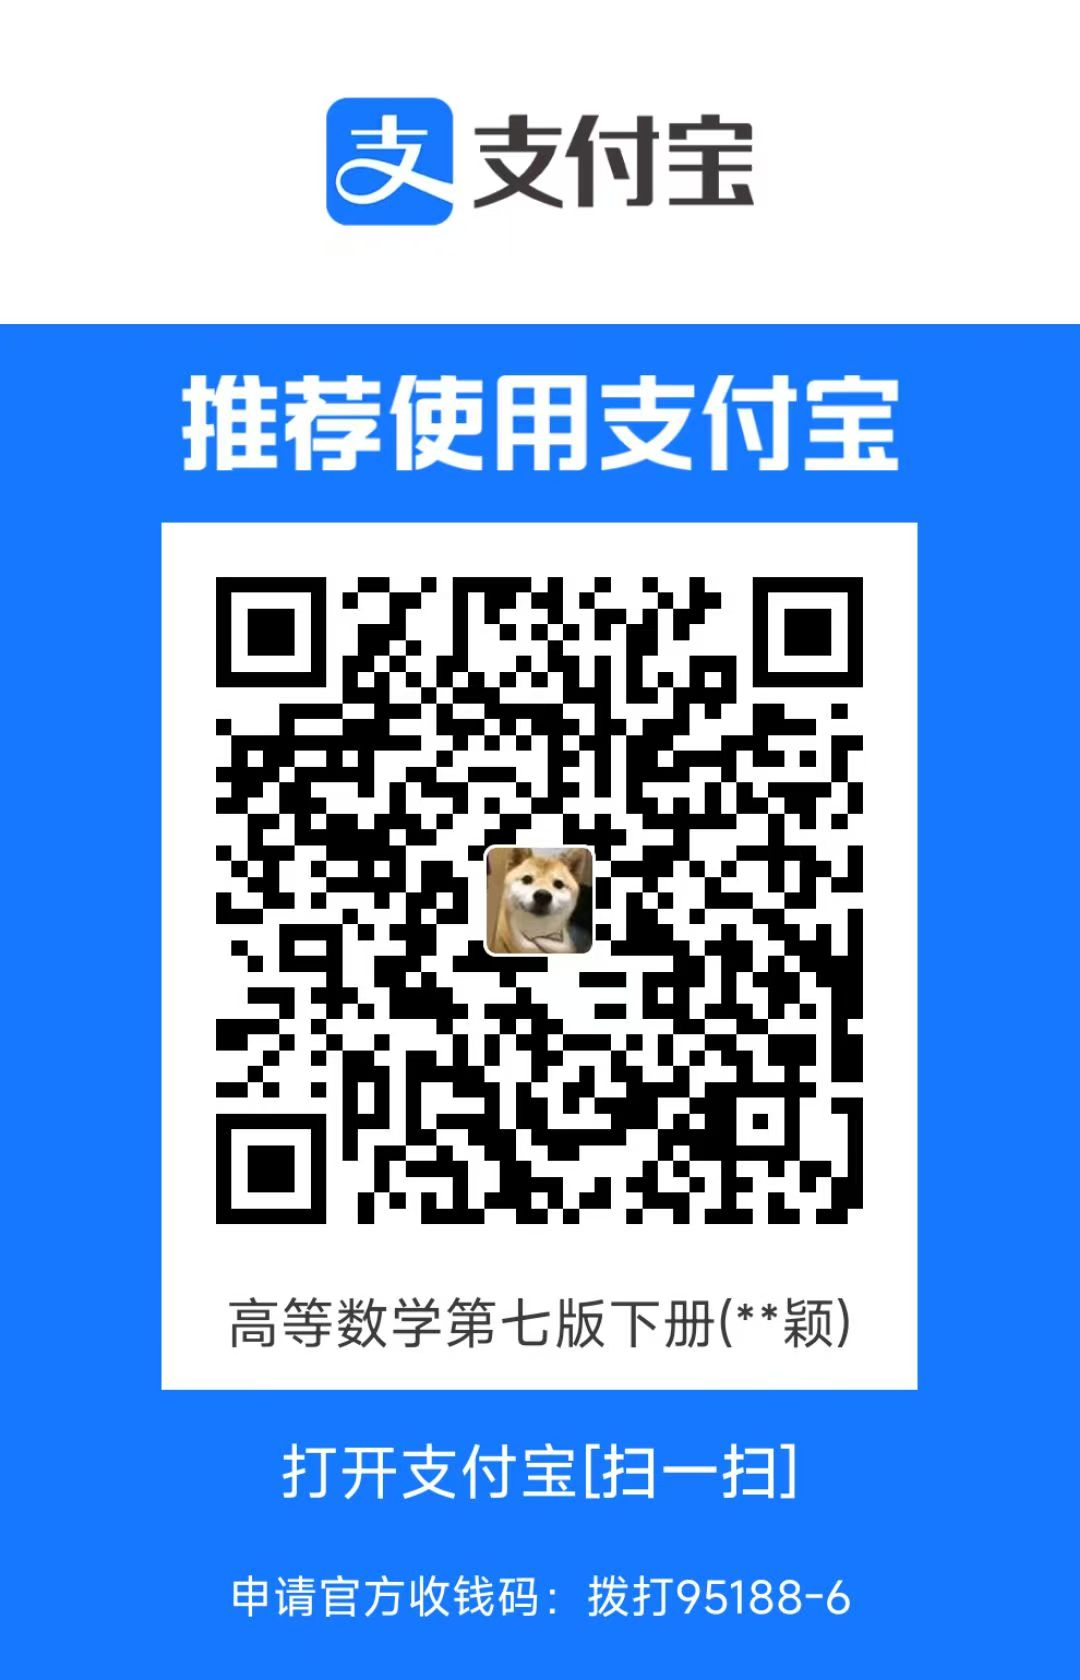